In [1]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

# Data analysis for LoopQ competition

In [2]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
cur_path = Path(ipynb_path)
train_info_path = (cur_path / "datasets/challengeA_data/2022challengeA_train.csv").resolve()
train_folder_path = (cur_path / "datasets/challengeA_data/train").resolve()

## Dataset information
The training and testing sets consist of audio files that were merged from 4 distinct data
sources (TESS , SAVEE , RAVDESS , CREMA ).  
The training set contains 10111 labeled audio files, and the testing set contains only the audio files and your task is to label each file.  
In more details:  
The file 2022challengeA_train.csv contains three columns:
- file_id: contains a string identifying the sound file
- emotion: contains a string representing the emotion of the person in the speech.
- origin: contains a string representing the origin dataset of the speeches.

In [3]:
# Load file
train_ds = pd.read_csv(train_info_path, index_col=0)
print("Dataset loaded, its shape is:", train_ds.shape)
print("Its columns are:", list(train_ds.columns))
# Check for rows with null values and drop them
null_rows = train_ds.isnull().any(axis=1)
print("There are ", null_rows.sum(), " rows with at least a null value, they will be dropped")

train_ds = train_ds[~null_rows]
train_size = train_ds.shape[0]
print("New shape:", train_ds.shape)

# Careful, some audio files have multiple audio channels

Dataset loaded, its shape is: (10111, 3)
Its columns are: ['file_id', 'emotion', 'origin']
There are  1  rows with at least a null value, they will be dropped
New shape: (10110, 3)


In [4]:
# Information about the labels
print("The emotions are:")
print(train_ds['emotion'].unique())
for g_name, group in train_ds.groupby("emotion"):
    group_size = group.shape[0]
    print(f"Emotion {g_name} has {group_size} samples, they are {group_size/train_size*100:.2f} % of the total")

The emotions are:
['fear' 'sadness' 'disgust' 'neutral' 'angry' 'happy' 'surprise']
Emotion angry has 1652 samples, they are 16.34 % of the total
Emotion disgust has 1629 samples, they are 16.11 % of the total
Emotion fear has 1628 samples, they are 16.10 % of the total
Emotion happy has 1634 samples, they are 16.16 % of the total
Emotion neutral has 1452 samples, they are 14.36 % of the total
Emotion sadness has 1555 samples, they are 15.38 % of the total
Emotion surprise has 560 samples, they are 5.54 % of the total


In [5]:
# Check how many audios are from each source
for g_name, group in train_ds.groupby("origin"):
    group_size = group.shape[0]
    print(f"Origin {g_name} has {group_size} samples, they are {group_size/train_size * 100:.2f} % of the training dataset")
    for in_g_name, in_group in group.groupby("emotion"):
        in_group_size = in_group.shape[0]
        print(f"{in_group_size} are {in_g_name}")
    print("")

Origin crema has 6306 samples, they are 62.37 % of the training dataset
1058 are angry
1085 are disgust
1082 are fear
1084 are happy
939 are neutral
1058 are sadness

Origin ravdess has 1041 samples, they are 10.30 % of the training dataset
163 are angry
154 are disgust
163 are fear
155 are happy
81 are neutral
162 are sadness
163 are surprise

Origin savee has 397 samples, they are 3.93 % of the training dataset
98 are angry
52 are disgust
51 are fear
48 are happy
97 are neutral
51 are surprise

Origin tess has 2366 samples, they are 23.40 % of the training dataset
333 are angry
338 are disgust
332 are fear
347 are happy
335 are neutral
335 are sadness
346 are surprise



## Interesting file information
Various information that we might be interested in about the files are:
- file length
- sampling rate
- average vaweform intensity
- fundamental frequency

In [6]:
import librosa

In [7]:
durations = []
sampling_rates = []
avg_intensities = []
maxs = []
mins = []
for i, row in train_ds.iterrows():
    file_name = row['file_id']
    file_path = (train_folder_path / file_name)
    durations += [librosa.get_duration(filename=file_path)]

    ts, sr = librosa.load(file_path, sr=None)

    avg_intensities += [np.mean(ts)]
    maxs += [np.max(ts)]
    mins += [np.min(ts)]

    sampling_rates += [sr]
print("Statistics about the entire dataset")
print(f"95th percentile of file length {np.percentile(durations, 99)}")
print(f"Avg file length: {np.mean(durations):.3f} seconds")
print(f"Std dev of file length: {np.std(durations):.3f} seconds")
print(f"Shorthest file: {np.min(durations):.3f} seconds")
print(f"Longest file: {np.max(durations):.3f} seconds")
print(f"Different sampling rates: {np.unique(sampling_rates)}")
print(f"Average intensitities: {np.mean(avg_intensities)}")
print(f"Average max intensities: {np.mean(maxs)}")
print(f"Average min intensities: {np.mean(mins)}") 

Statistics about the entire dataset
95th percentile of file length 4.804810625
Avg file length: 2.597 seconds
Std dev of file length: 0.706 seconds
Shorthest file: 1.254 seconds
Longest file: 7.139 seconds
Different sampling rates: [16000 24414 44100 48000]
Average intensitities: 0.0009323562262579799
Average max intensities: 0.2796539068222046
Average min intensities: -0.27516889572143555


In [13]:
to_group = ["emotion", "origin"]
for grouping in to_group:
    print("Statistics grouped by ", grouping)
    for g_name, group in train_ds.groupby(grouping):
        durations = []
        sampling_rates = []
        avg_intensities = []
        maxs = []
        mins = []
        for i, row in group.iterrows():
            file_name = row['file_id']
            file_path = (train_folder_path / file_name)
            durations += [librosa.get_duration(filename=file_path)]

            ts, sr = librosa.load(file_path, sr=None)

            avg_intensities += [np.mean(ts)]
            maxs += [np.max(ts)]
            mins += [np.min(ts)]    
            sampling_rates += [sr]

        print(grouping, ":", g_name, "\n")
        print(f"Avg file length: {np.mean(durations):.3f} seconds")
        print(f"Shorthest file: {np.min(durations):.3f} seconds")
        print(f"Longest file: {np.max(durations):.3f} seconds")
        print(f"Different sampling rates: {np.unique(sampling_rates)}")
        print(f"Average intensitities: {np.mean(avg_intensities)}")
        print(f"Average max intensities: {np.mean(maxs)}")
        print(f"Average min intensities: {np.mean(mins)}\n") 
    print("-"*20)
    print("\n\n")

Statistics grouped by  emotion
emotion : angry 

Avg file length: 2.663 seconds
Shorthest file: 1.288 seconds
Longest file: 7.139 seconds
Different sampling rates: [16000 24414 44100 48000]
Average intensitities: 0.0013876280281692743
Average max intensities: 0.5750070810317993
Average min intensities: -0.5598493814468384

emotion : disgust 

Avg file length: 2.853 seconds
Shorthest file: 1.268 seconds
Longest file: 7.013 seconds
Different sampling rates: [16000 24414 44100 48000]
Average intensitities: 0.0008496011723764241
Average max intensities: 0.21137025952339172
Average min intensities: -0.20223596692085266

emotion : fear 

Avg file length: 2.478 seconds
Shorthest file: 1.254 seconds
Longest file: 5.912 seconds
Different sampling rates: [16000 24414 44100 48000]
Average intensitities: 0.0006645339308306575
Average max intensities: 0.2864474058151245
Average min intensities: -0.2849459946155548

emotion : happy 

Avg file length: 2.429 seconds
Shorthest file: 1.335 seconds
Longe

## Data visualization
Let's visualize some plots about the files grouped by emotion.
In particular the sound wave and the mel spectrogram.

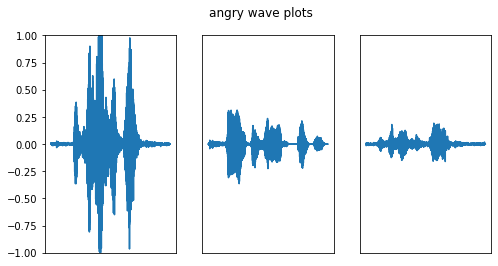

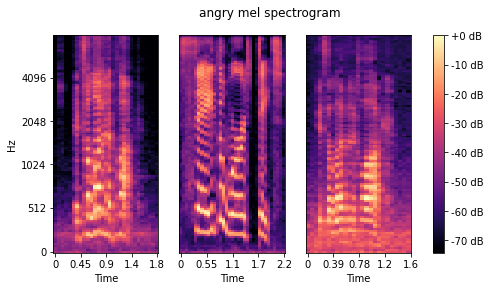

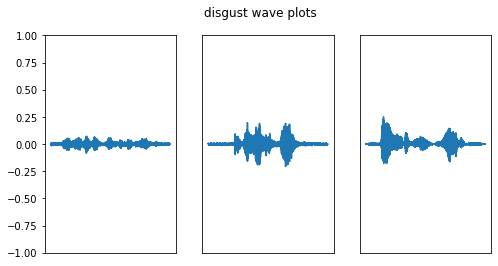

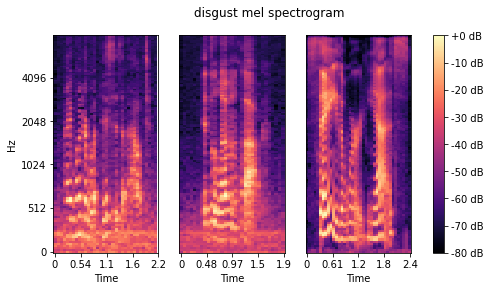

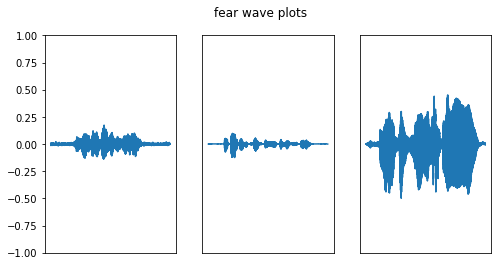

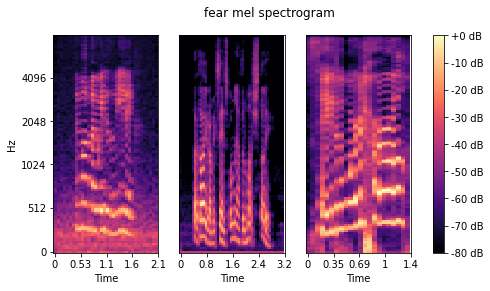

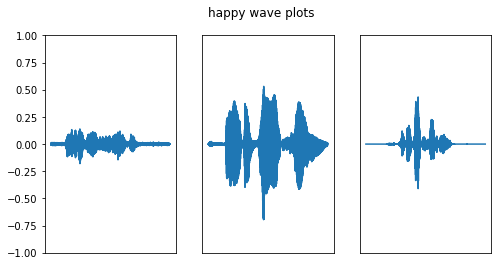

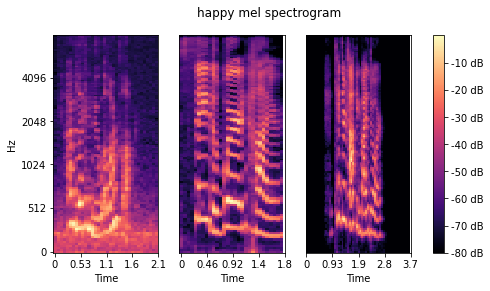

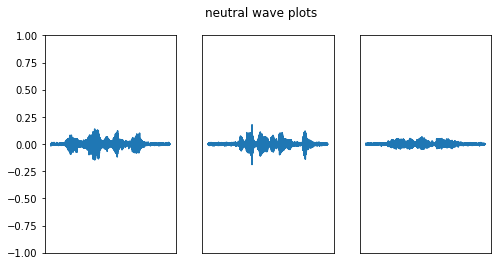

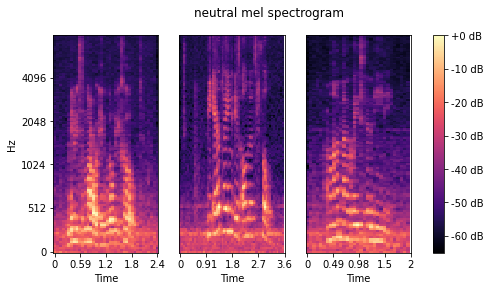

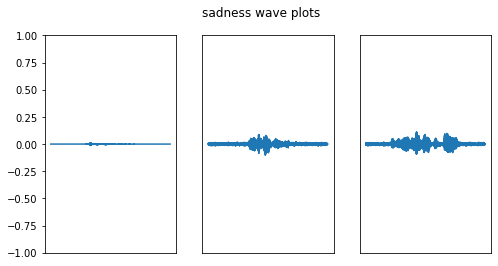

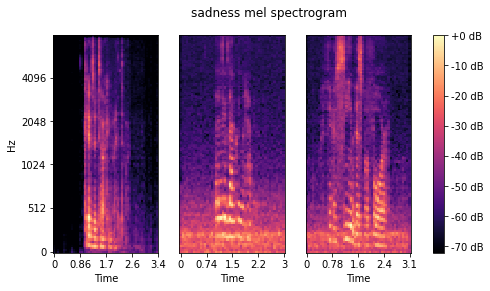

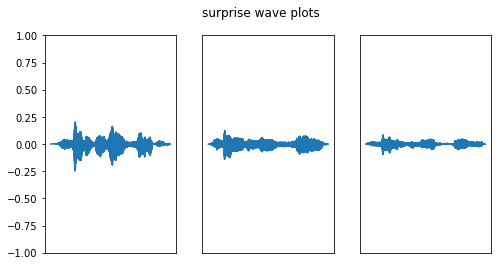

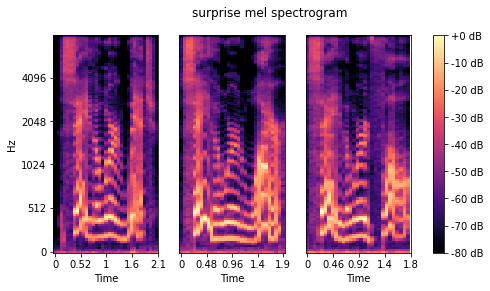

In [54]:
graph_cols = 3

for g_name, group in train_ds.groupby("emotion"):
    chosen = np.random.choice(len(group), graph_cols)
    
    fig1, axs1 = plt.subplots(1,graph_cols, figsize=(8,4))
    fig2, axs2 = plt.subplots(1,graph_cols, figsize=(8,4))

    fig1.suptitle(g_name + " wave plots")
    fig2.suptitle(g_name + " mel spectrogram")


    min_db = 100
    for c, i in enumerate(chosen):
        file_path = (train_folder_path / group.iloc[i]['file_id'])
        y, sr = librosa.load(file_path, sr=16000)
        
        #axs[1,c].sharex(axs[0,c])
        axs1[c].axes.get_xaxis().set_visible(False)

        if c != 0:
            axs1[c].sharey(axs1[c-1])
            axs1[c].axes.get_yaxis().set_visible(False)

        axs1[c].set_ylim([-1,1])
        axs1[c].plot(range(len(y)), y)

        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        mel_spect = librosa.power_to_db(spect, ref=np.max)
        
        min_db_f = np.amin(mel_spect)
        if min_db_f < min_db:
            min_db = min_db_f
        
        img = librosa.display.specshow(mel_spect, sr=sr/2, y_axis='mel', fmax=8000, x_axis='time', ax=axs2[c])

        axs2[c].set_xticks(np.linspace(0, len(y)/sr, 5)) 
        #axs[1,c].axes.get_yaxis().set_visible(False)

        if c != 0:
            axs2[c].sharey(axs2[c-1])
            axs2[c].axes.get_yaxis().set_visible(False)
        #axs[1,c].imshow(mel_spect)
        if c == graph_cols - 1:
            #fig.subplots_adjust(right=0.8)
            #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig2.colorbar(img, ax=axs2.ravel(), format="%+2.f dB")

            
    


## Remove silence 

In [3]:
from torchaudio.transforms import Vad
import torch
import soundfile as sf

chosen_files = np.random.choice(len(train_ds), 3)

fig, axs = plt.subplots(len(chosen_files), 3, figsize=(8,8))
for i, idx in enumerate(chosen_files):

    file_path = (train_folder_path / train_ds.iloc[idx]['file_id'])
    y, sr = librosa.load(file_path, sr=16000)
    
    axs[i,0].set_ylim([-1,1])

    axs[i,1].sharey(axs[i,0])
    axs[i,2].sharey(axs[i,0])

    axs[i,1].axes.get_yaxis().set_visible(False)
    axs[i,2].axes.get_yaxis().set_visible(False)

    
    axs[i, 0].plot(range(len(y)), y)

    y_trim, trim_idx= librosa.effects.trim(y, top_db=20)
    axs[i,1].plot(range(len(y_trim)), y_trim)

    tuned_vad = Vad(16000, trigger_level=1)

    y_vad = torch.flip(
                tuned_vad(
                    torch.flip(
                        tuned_vad(torch.as_tensor(y)),
                    (0,)), 
                )
                ,(0,))
    axs[i,2].plot(range(len(y_vad)), y_vad)

    """
    sf.write(f'orig_{i}.wav', y, 16000, 'PCM_24')
    sf.write(f'trim_{i}.wav', y_trim, 16000, 'PCM_24')
    sf.write(f'vad_{i}.wav', y_vad, 16000, 'PCM_24')
    """


/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'train_ds' is not defined

## Compare different emotion spectrograms   

angry
disgust
fear
happy
neutral
sadness
surprise


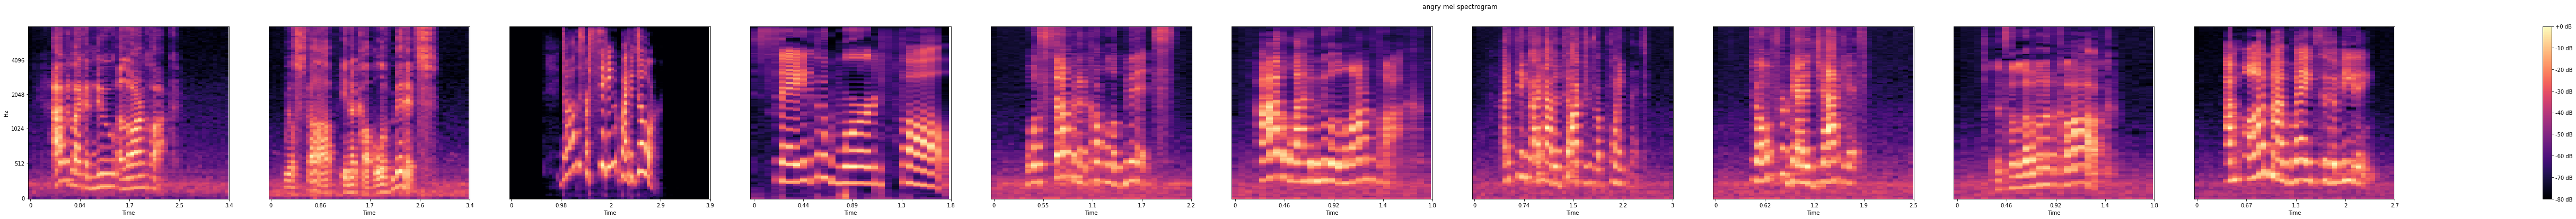

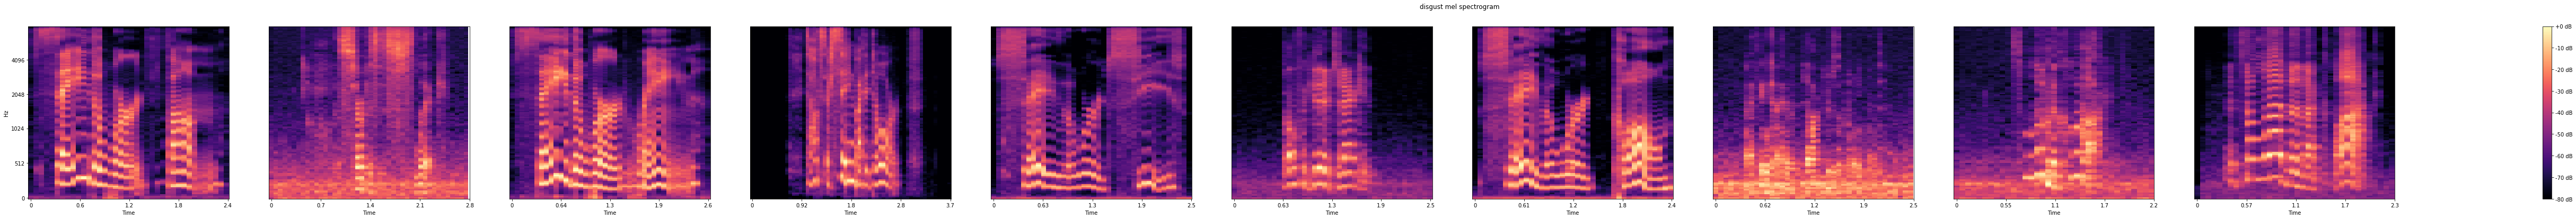

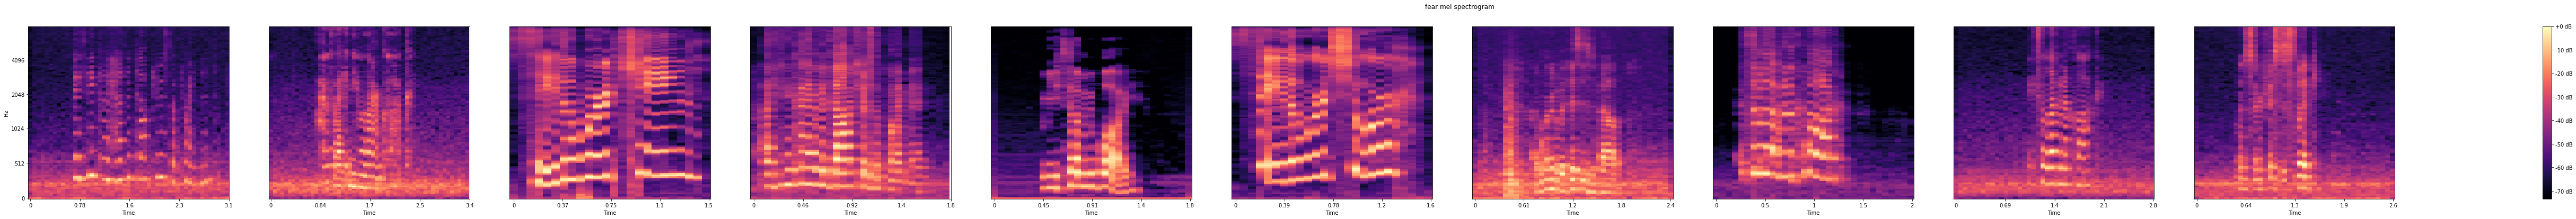

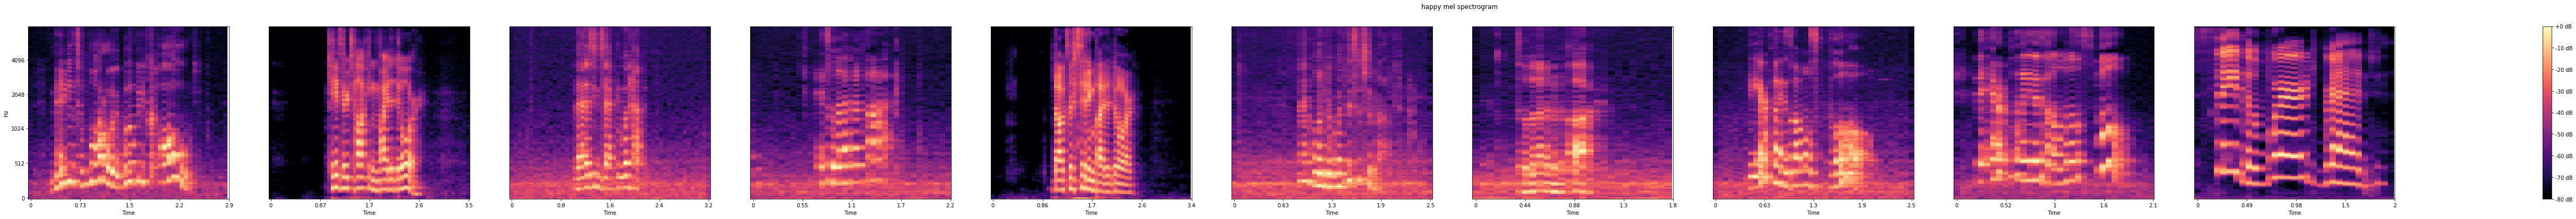

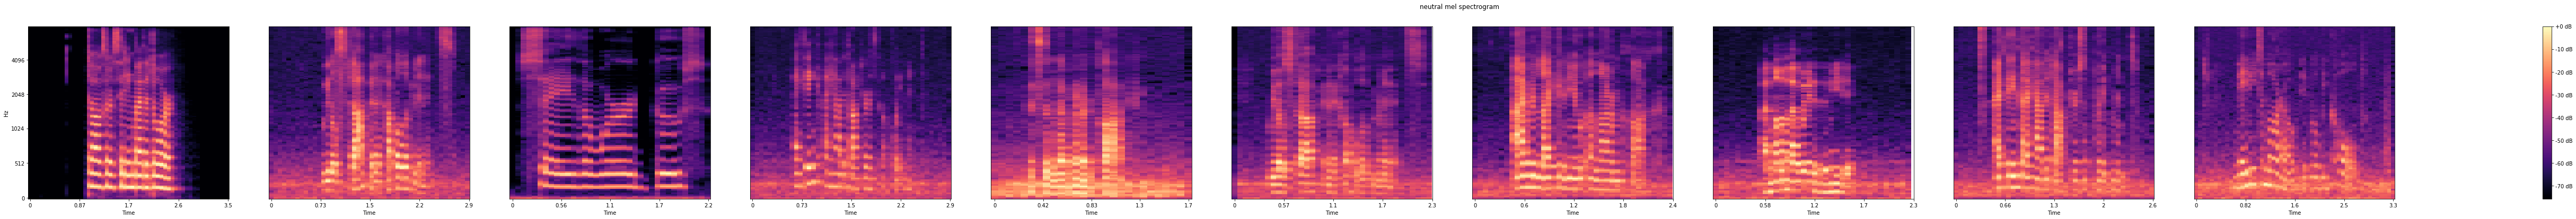

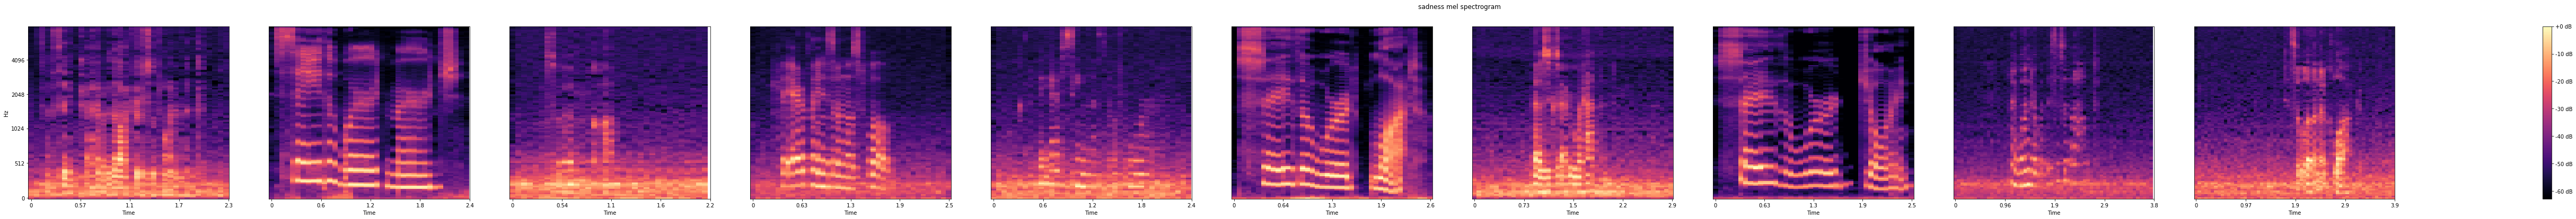

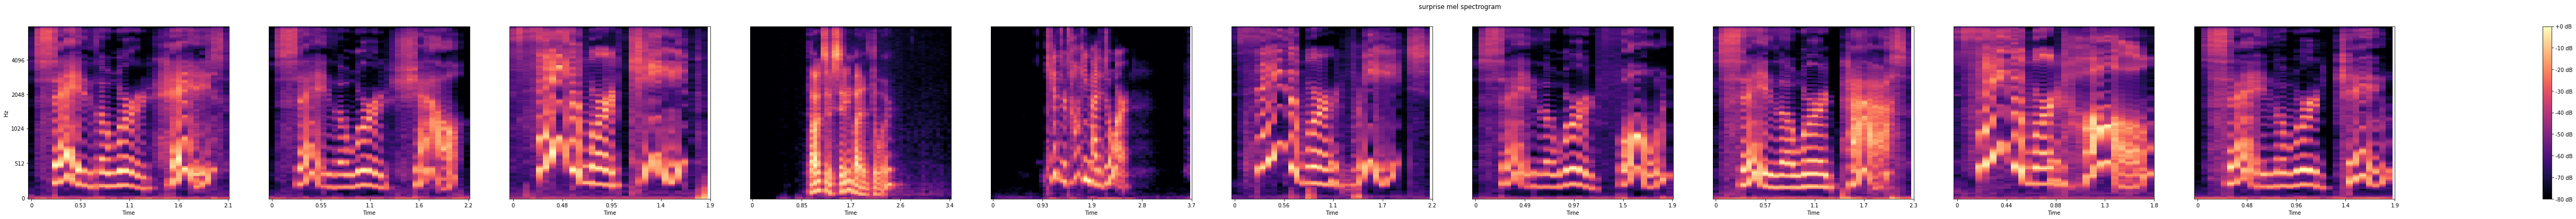

In [30]:
graph_cols = 10

for g_name, group in train_ds.groupby("emotion"):
    chosen = np.random.choice(len(group), graph_cols)
    
    fig2, axs2 = plt.subplots(1,graph_cols, figsize=(100,6))

    fig2.suptitle(g_name + " mel spectrogram")
    print(g_name)

    min_db = 100
    for c, i in enumerate(chosen):
        file_path = (train_folder_path / group.iloc[i]['file_id'])
        y, sr = librosa.load(file_path, sr=16000)
        

        spect = np.abs(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024))
        mel_spect = librosa.power_to_db(spect, ref=np.max)

        #S = np.abs(librosa.stft(y))
        #comps, acts = librosa.decompose.decompose(S, n_components=8, sort=True)

        min_db_f = np.amin(mel_spect)
        if min_db_f < min_db:
            min_db = min_db_f


        img = librosa.display.specshow(mel_spect, sr=sr/2, y_axis='mel', fmax=8000, x_axis='time', ax=axs2[c])
        #img = librosa.display.specshow(librosa.amplitude_to_db(acts,ref=np.max), y_axis='log', ax=axs2[c])

        axs2[c].set_xticks(np.linspace(0, len(y)/sr, 5)) 
        #axs[1,c].axes.get_yaxis().set_visible(False)

        if c != 0:
            axs2[c].sharey(axs2[c-1])
            axs2[c].axes.get_yaxis().set_visible(False)
        #axs[1,c].imshow(mel_spect)
        if c == graph_cols - 1:
            #fig.subplots_adjust(right=0.8)
            #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig2.colorbar(img, ax=axs2.ravel(), format="%+2.f dB")